# Convergence Analysis of Adapted Empirical Measure and Discrete Optimal Transport Performance

## Overview
This notebook investigates the convergence properties of the adapted empirical measure and evaluates the performance of discrete optimal transport calculations on larger trees. The study consists of:

1. **Generating and Comparing Two Brownian Motion Adapted Trees**
   - We sample paths from two Brownian motions.
   - Construct adapted trees for each.
   - Compare the values obtained against benchmark values.

2. **Benchmarking**
   - Compute the theoretical adapted Wasserstein distance.
   - Validate results against numerical computations using discrete trees.

This approach helps assess the accuracy and efficiency of the empirical adapted measure in capturing the underlying stochastic process.

In [1]:
import sys
import os
import numpy as np
import warnings
import time
import random
import matplotlib.pyplot as plt

# Get the absolute path of src/ directory
notebooks_path = os.path.abspath(os.getcwd())  # Get the notebook’s current directory
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))

# Ensure src is in sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)  # Insert at the beginning to prioritize it

# Import necessary modules
from Measure_sampling.Gen_Path_and_AdaptedTrees import generate_adapted_tree
from trees.Tree_Node import *
from trees.TreeAnalysis import *
from trees.TreeVisualization import *
from trees.Save_Load_trees import *
from trees.Tree_AWD_utilities import *
from trees.Build_trees_from_paths import build_tree_from_paths

from adapted_empirical_measure.AEM_grid import *
from adapted_empirical_measure.AEM_kMeans import *

from benchmark_value_gaussian.Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from awd_trees.Gurobi_AOT import *
from awd_trees.Nested_Dist_Algo import compute_nested_distance

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Setting up measure and parameters

Non tirival number of time steps:
3
L:
[[1 0 0]
 [1 2 0]
 [1 2 3]]
A = LL^T:
[[ 1  1  1]
 [ 1  5  5]
 [ 1  5 14]]

M:
[[1 0 0]
 [2 1 0]
 [3 2 1]]
B = MM^T:
[[ 1  2  3]
 [ 2  5  8]
 [ 3  8 14]]


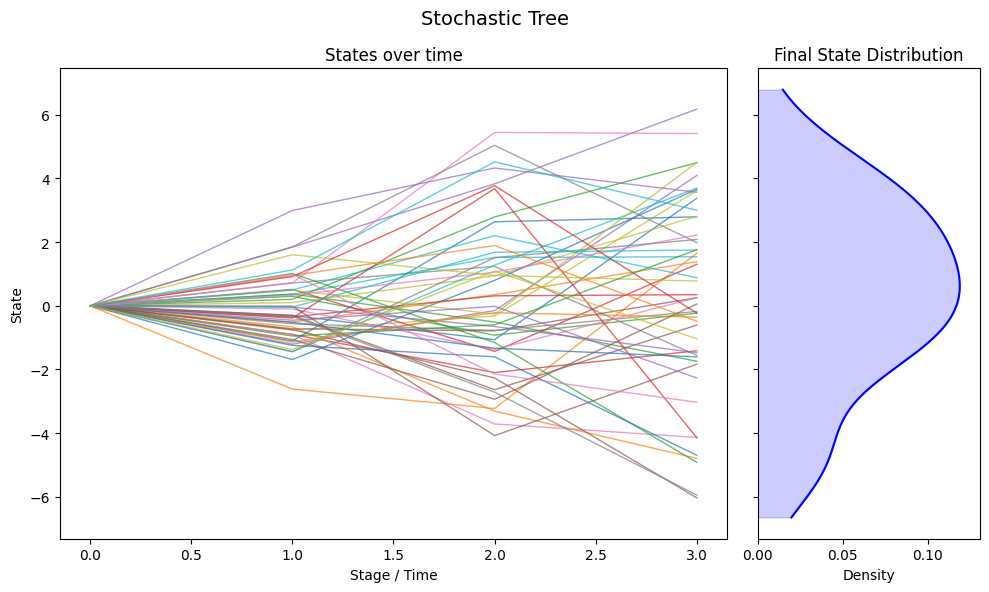

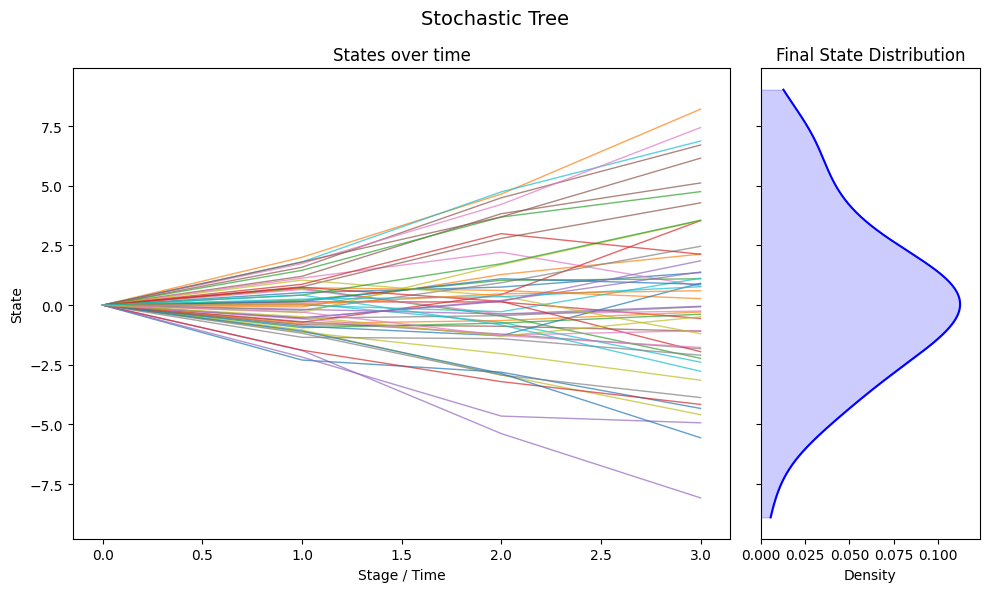

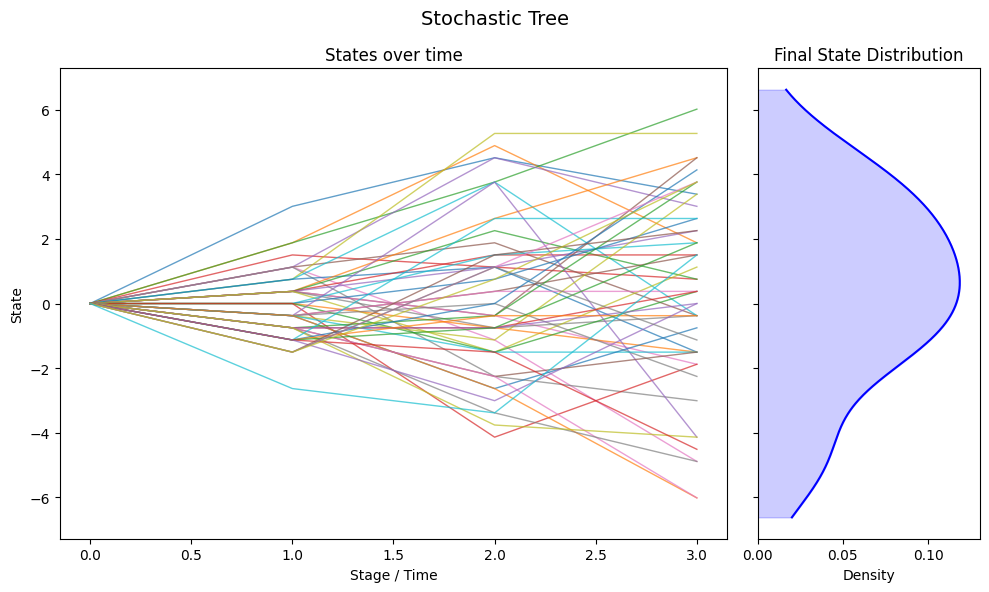

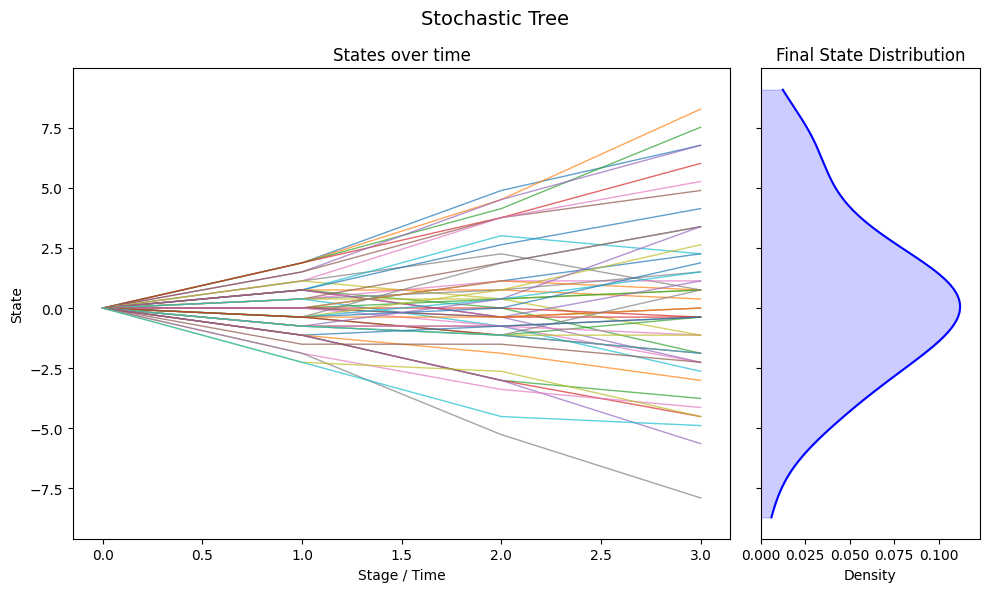

In [2]:
######################################
# Should be changed every different Experiment
######################################


dim = 3            # CHANGE EVERYTIME
normalize = False  # Whether to normalize the factor matrices

# Factor matrix L and its covariance A = L L^T
L0 = np.array([[1, 0, 0],
               [1, 2, 0],
               [1, 2, 3]])  # CHANGE EVERYTIME
A0 = L0 @ L0.T  # A0 = L0 L0^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T

# Factor matrix M and its covariance B = M M^T
M0 = np.array([[1, 0, 0],
               [2, 1, 0],
               [3, 2, 1]])  # CHANGE EVERYTIME
B0 = M0 @ M0.T  # B0 = M0 M0^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T


######################################



######################################
# Experiment parameters
######################################
n_runs = 10

methods = ["uniform_grid"]  # alternatives: ["kmeans", "kmeans_new", "kmeans_grid", "grid"]
time_steps = dim + 1

# Define sample path sizes for each time step
sample_sizes_map = {
    2: [200, 500, 1000, 2000, 4000, 8000],
    3: [200, 500, 1000, 2000, 4000],
    4: [200, 500, 1000, 2000, 3000],
    5: [200, 500, 1000, 2000],
    6: [200, 500, 1000, 1500],
}

##################################




###############################
# Show the set up
################################


print("Non tirival number of time steps:")
print(dim)
print("L:")
print(L)
print("A = LL^T:")
print(A)
print("\nM:")
print(M)
print("B = MM^T:")
print(B)

# Generate sample paths for plotting
n_sample_plot = 50
noise1 = np.random.normal(size=(dim, n_sample_plot))
noise2 = np.random.normal(size=(dim, n_sample_plot))
# Create paths (each column is a path with 'dim' entries)
X = L @ noise1
Y = M @ noise2  # Can use the same noise!
# Prepend a trivial first step (e.g. zero); shape becomes (dim+1, n_sample)
X = np.concatenate([np.zeros((1, n_sample_plot)), X], axis=0)
Y = np.concatenate([np.zeros((1, n_sample_plot)), Y], axis=0)

# Set equal weights for each sample path (assumed identical in the trivial first step)
iid_weight = np.ones((1, n_sample_plot)) / n_sample_plot

X = X.T
Y = Y.T
iid_weight = iid_weight[0]

# Build trees from the original paths
tree_1 = build_tree_from_paths(X, iid_weight)
tree_2 = build_tree_from_paths(Y, iid_weight)

# Adapt the empirical measure using uniform grid quantization
adapted_X, adapted_weights_X = uniform_empirical_grid_measure(X, use_weights = True)
adapted_Y, adapted_weights_Y = uniform_empirical_grid_measure(Y, use_weights = True)

# Build trees from the adapted paths
adapted_tree_1 = build_tree_from_paths(adapted_X, adapted_weights_X)
adapted_tree_2 = build_tree_from_paths(adapted_Y, adapted_weights_Y)

# Visualize the trees
visualize_big_tree(tree_1)
visualize_big_tree(tree_2)
visualize_big_tree(adapted_tree_1)
visualize_big_tree(adapted_tree_2)


# Checking conv for Grid over the Gaussian

Time Steps: 4, Method: uniform_grid, Run 1/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 2/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 3/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 4/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 5/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 6/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 7/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 8/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 9/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 10/10 for sample size 200...
Time Steps: 4, Method: uniform_grid, Run 1/10 for sample size 500...
Time Steps: 4, Method: uniform_grid, Run 2/10 for sample size 500...
Time Steps: 4, Method: uniform_grid, Run 3/10 for sample size 500...
Time Steps: 4, Method: uniform_grid, Run 4/10 for sample size 500...
Time Steps: 4, Method: uniform_gr

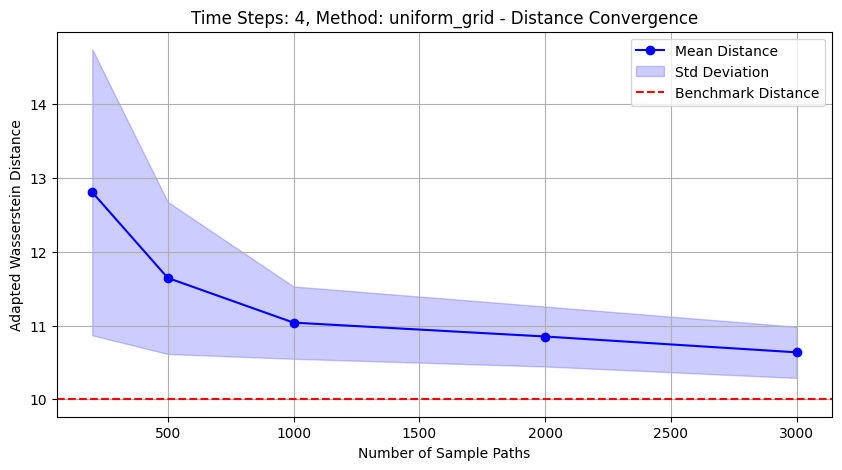

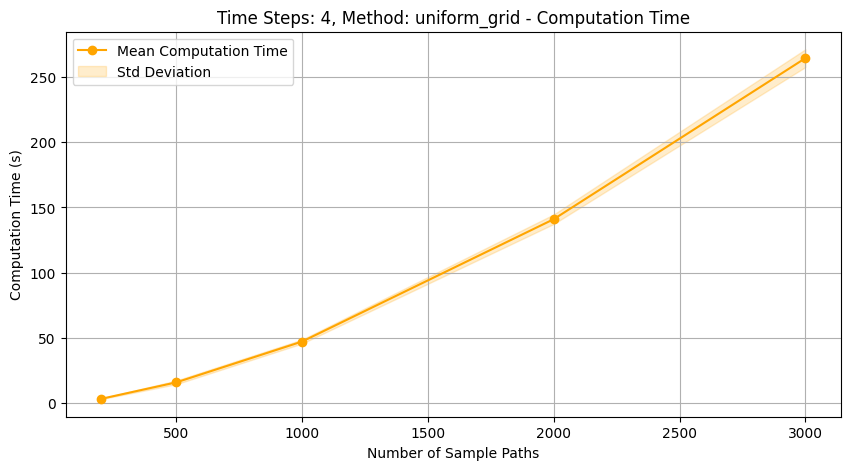

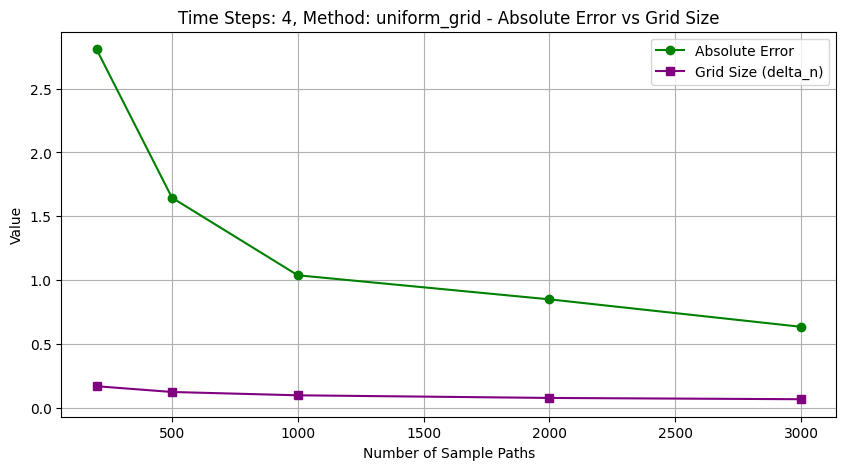

In [3]:
# Select the corresponding sample sizes for the current time step
sample_sizes = sample_sizes_map[time_steps]

# Choose method (note: fixing typo to "uniform grid" if needed)
method = "uniform_grid"

# Arrays to store results for the current time_steps and method
distances_all = np.zeros((len(sample_sizes), n_runs))
times_all = np.zeros((len(sample_sizes), n_runs))

# Compute the benchmark adapted Wasserstein distance once for this time step
# Note: using t = time_steps - 1 as in your original code, here t = dim
t = dim
distance_squared = adapted_wasserstein_squared(np.zeros((t,)), A, np.zeros((t,)), B)

# Loop over each sample size and run n_runs for statistics
for i, num_paths in enumerate(sample_sizes):
    for run_idx in range(n_runs):
        print(f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}...")
        noise1 = np.random.normal(size=(dim, num_paths))
        noise2 = np.random.normal(size=(dim, num_paths))
        # Create paths (each column is a path with 'dim' entries)
        X = L @ noise1
        Y = M @ noise2  # Can use the same noise!
        # Prepend a trivial first step (e.g. zero); shape becomes (dim+1, num_paths)
        X = np.concatenate([np.zeros((1, num_paths)), X], axis=0)
        Y = np.concatenate([np.zeros((1, num_paths)), Y], axis=0)
        # Transpose so that each row is a path
        X = X.T
        Y = Y.T

        # Adapt the empirical measure using uniform grid quantization
        adapted_X, adapted_weights_X = uniform_empirical_grid_measure(X, use_weights=True)
        adapted_Y, adapted_weights_Y = uniform_empirical_grid_measure(Y, use_weights=True)

        # Build trees from the adapted paths
        adapted_tree_1 = build_tree_from_paths(adapted_X, adapted_weights_X)
        adapted_tree_2 = build_tree_from_paths(adapted_Y, adapted_weights_Y)

        # Compute the nested (adapted optimal transport) distance and timing
        max_depth = get_depth(adapted_tree_1)
        start_time = time.time()
        distance_pot = compute_nested_distance(
            adapted_tree_1,
            adapted_tree_2,
            max_depth,
            method="solver_lp_pot",
            return_matrix=False,
            lambda_reg=0,
            power=2,
        )
        elapsed_time_pot = time.time() - start_time

        # Store the computed distance and time
        distances_all[i, run_idx] = distance_pot
        times_all[i, run_idx] = elapsed_time_pot

# Compute statistics over runs
distances_mean = distances_all.mean(axis=1)
distances_std = distances_all.std(axis=1)
times_mean = times_all.mean(axis=1)
times_std = times_all.std(axis=1)

# ---------------------------------------------------------
# PLOT 1: Distance convergence with mean ± std band
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, distances_mean, marker="o", color="blue", label="Mean Distance")
plt.fill_between(
    sample_sizes,
    distances_mean - distances_std,
    distances_mean + distances_std,
    color="blue",
    alpha=0.2,
    label="Std Deviation",
)
plt.axhline(y=distance_squared, color="red", linestyle="--", label="Benchmark Distance")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Distance")
plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Convergence")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------------------------------
# PLOT 2: Computation time with mean ± std band
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, times_mean, marker="o", color="orange", label="Mean Computation Time")
plt.fill_between(
    sample_sizes,
    times_mean - times_std,
    times_mean + times_std,
    color="orange",
    alpha=0.2,
    label="Std Deviation",
)
plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (s)")
plt.title(f"Time Steps: {time_steps}, Method: {method} - Computation Time")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------------------------------
# PLOT 3: Error plot with grid size
# ---------------------------------------------------------
# Compute the absolute error between benchmark and computed distances
error_mean = np.abs(distance_squared - distances_mean)

# Compute grid sizes for each sample size using the formula:
# delta_n = 1 / (num_paths^(1/t))
grid_sizes = np.array([1 / (num_paths ** (1 / t)) for num_paths in sample_sizes])

plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, error_mean, marker='o', color='green', label='Absolute Error')
plt.plot(sample_sizes, grid_sizes, marker='s', color='purple', label='Grid Size (delta_n)')
plt.xlabel("Number of Sample Paths")
plt.ylabel("Value")
plt.title(f"Time Steps: {time_steps}, Method: {method} - Absolute Error vs Grid Size")
plt.legend()
plt.grid()
plt.show()

## Checking convergence of adapted measure with multiple techniques

Method: grid
Time Steps: 4, Method: grid, Run 1/10 for sample size 200...
Time Steps: 4, Method: grid, Run 2/10 for sample size 200...
Time Steps: 4, Method: grid, Run 3/10 for sample size 200...
Time Steps: 4, Method: grid, Run 4/10 for sample size 200...
Time Steps: 4, Method: grid, Run 5/10 for sample size 200...
Time Steps: 4, Method: grid, Run 6/10 for sample size 200...
Time Steps: 4, Method: grid, Run 7/10 for sample size 200...
Time Steps: 4, Method: grid, Run 8/10 for sample size 200...
Time Steps: 4, Method: grid, Run 9/10 for sample size 200...
Time Steps: 4, Method: grid, Run 10/10 for sample size 200...
Time Steps: 4, Method: grid, Run 1/10 for sample size 500...
Time Steps: 4, Method: grid, Run 2/10 for sample size 500...
Time Steps: 4, Method: grid, Run 3/10 for sample size 500...
Time Steps: 4, Method: grid, Run 4/10 for sample size 500...
Time Steps: 4, Method: grid, Run 5/10 for sample size 500...
Time Steps: 4, Method: grid, Run 6/10 for sample size 500...
Time Steps

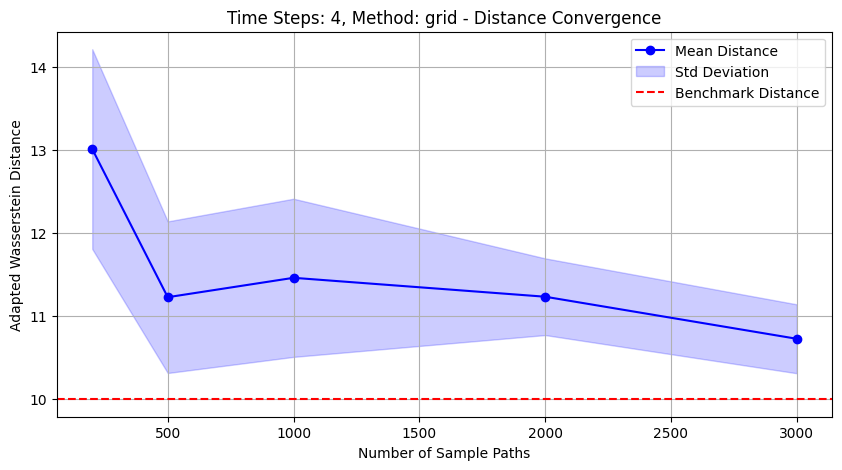

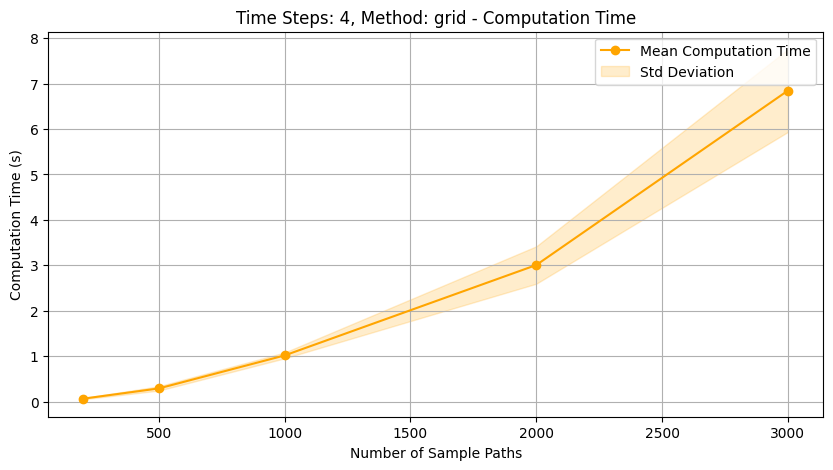

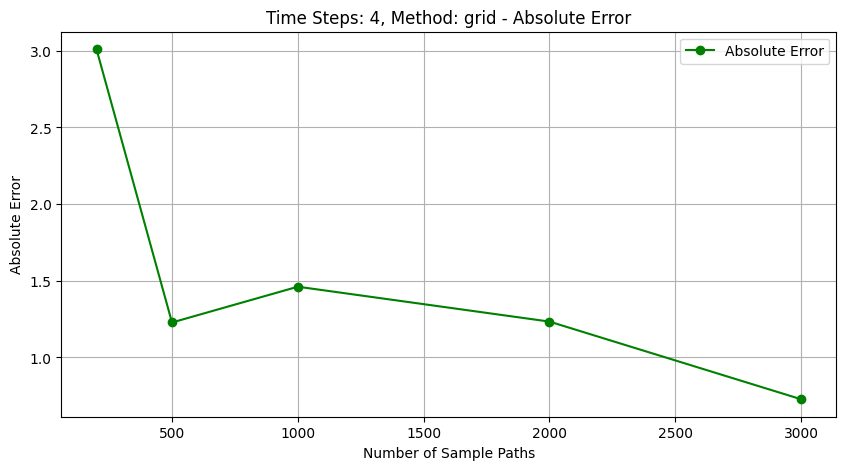

Method: kmeans
Time Steps: 4, Method: kmeans, Run 1/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 2/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 3/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 4/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 5/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 6/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 7/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 8/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 9/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 10/10 for sample size 200...
Time Steps: 4, Method: kmeans, Run 1/10 for sample size 500...
Time Steps: 4, Method: kmeans, Run 2/10 for sample size 500...
Time Steps: 4, Method: kmeans, Run 3/10 for sample size 500...
Time Steps: 4, Method: kmeans, Run 4/10 for sample size 500...
Time Steps: 4, Method: kmeans, Run 5/10 for sample size 500...
Time Steps: 4, Method: kmeans, Run 6/10

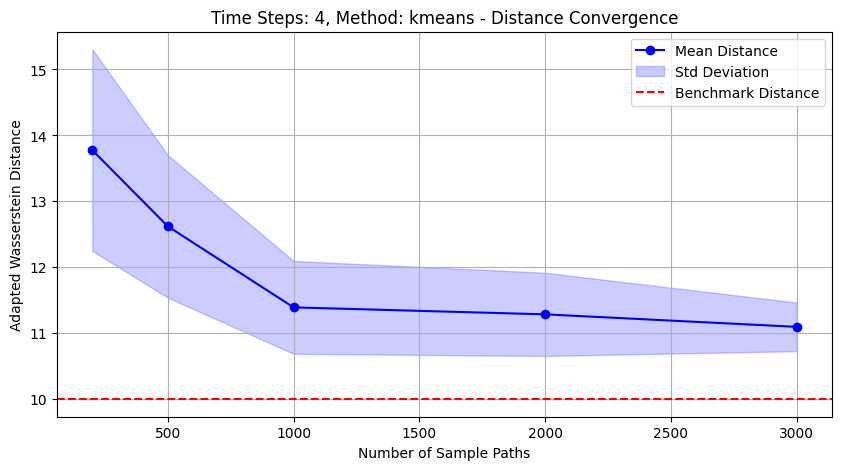

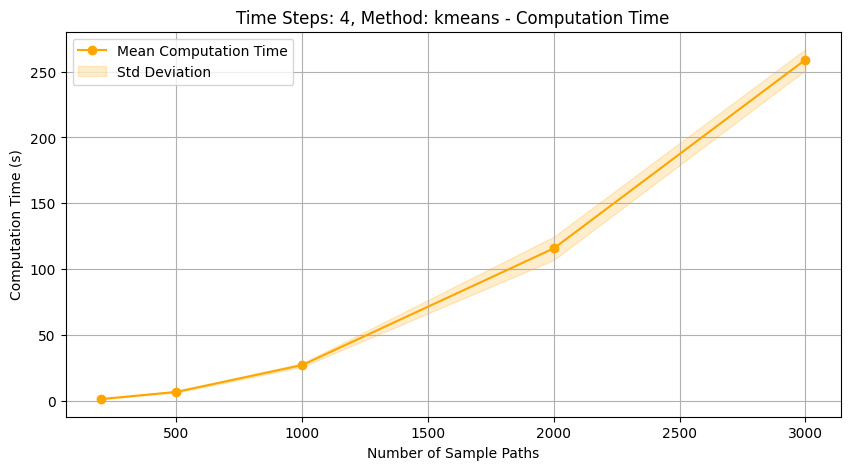

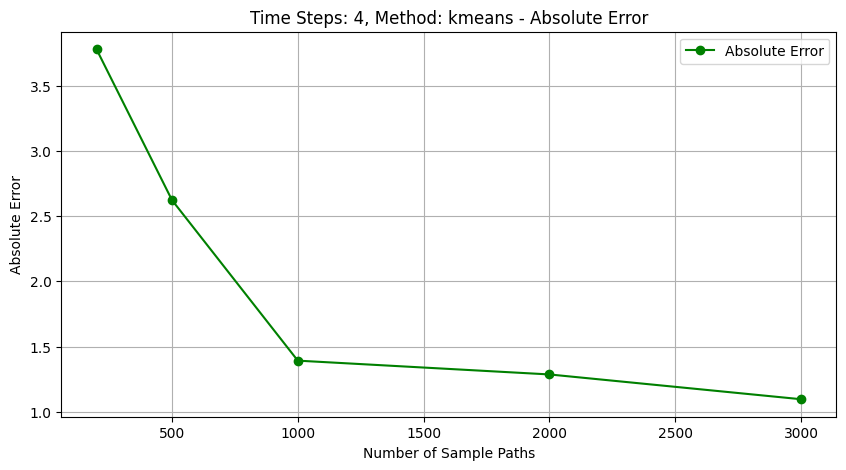

Method: kmeans_new
Time Steps: 4, Method: kmeans_new, Run 1/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 2/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 3/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 4/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 5/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 6/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 7/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 8/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 9/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 10/10 for sample size 200...
Time Steps: 4, Method: kmeans_new, Run 1/10 for sample size 500...
Time Steps: 4, Method: kmeans_new, Run 2/10 for sample size 500...
Time Steps: 4, Method: kmeans_new, Run 3/10 for sample size 500...
Time Steps: 4, Method: kmeans_new, Run 4/10 for sample size 500...
Time Steps: 4, Method: kmeans_new, Run 5/1

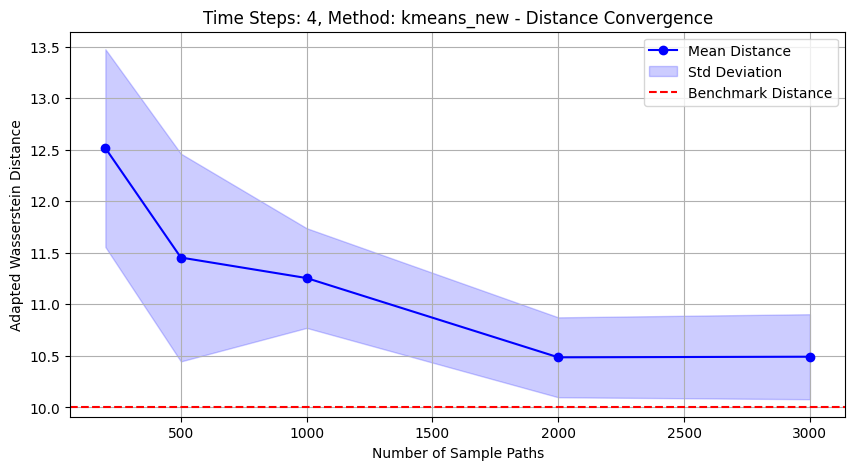

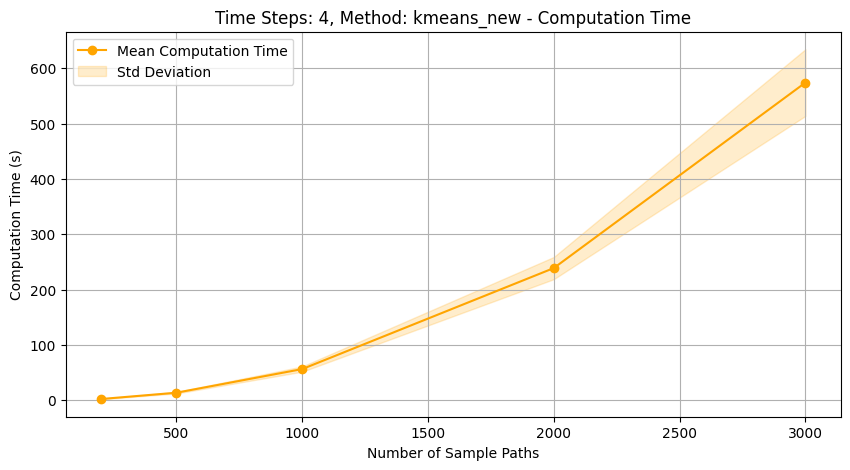

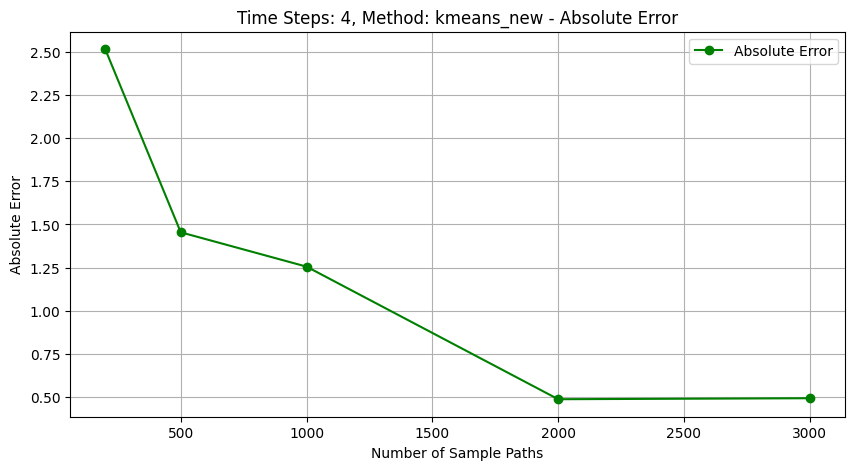

In [4]:
methods = ["grid", "kmeans", "kmeans_new"]

sample_sizes = sample_sizes_map[time_steps]

for method in methods:
    print(f"Method: {method}")
    
    # Select the empirical measure adaptation function based on the method name
    if method == "grid":
        measure_func = empirical_grid_measure
    elif method == "unifrom_gird":
        measure_func = uniform_empirical_grid_measure
    elif method == "kmeans":
        measure_func = empirical_k_means_measure
    elif method == "kmeans_new":
        measure_func = empirical_k_means_measure_new
    else:
        raise ValueError(f"Unknown method: {method}")
        
    # Arrays to store results for the current time_steps and method
    distances_all = np.zeros((len(sample_sizes), n_runs))
    times_all = np.zeros((len(sample_sizes), n_runs))
    
    # Loop over each sample size and run n_runs for statistics
    for i, num_paths in enumerate(sample_sizes):
        for run_idx in range(n_runs):
            print(f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}...")
            noise1 = np.random.normal(size=(dim, num_paths))
            noise2 = np.random.normal(size=(dim, num_paths))
            # Create paths (each column is a path with 'dim' entries)
            X = L @ noise1
            Y = M @ noise2  # Can use the same noise!
            # Prepend a trivial first step (e.g., zero); shape becomes (dim+1, num_paths)
            X = np.concatenate([np.zeros((1, num_paths)), X], axis=0)
            Y = np.concatenate([np.zeros((1, num_paths)), Y], axis=0)
            # Transpose so that each row is a path
            X = X.T
            Y = Y.T
            
            # Adapt the empirical measure using the selected method
            adapted_X, adapted_weights_X = measure_func(X, use_weights=True)
            adapted_Y, adapted_weights_Y = measure_func(Y, use_weights=True)
            
            # Build trees from the adapted paths
            adapted_tree_1 = build_tree_from_paths(adapted_X, adapted_weights_X)
            adapted_tree_2 = build_tree_from_paths(adapted_Y, adapted_weights_Y)
            
            # Compute the nested (adapted optimal transport) distance and timing
            max_depth = get_depth(adapted_tree_1)
            start_time = time.time()
            distance_pot = compute_nested_distance(
                adapted_tree_1,
                adapted_tree_2,
                max_depth,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )
            elapsed_time_pot = time.time() - start_time
            
            # Store the computed distance and time
            distances_all[i, run_idx] = distance_pot
            times_all[i, run_idx] = elapsed_time_pot

    # Compute statistics over runs
    distances_mean = distances_all.mean(axis=1)
    distances_std = distances_all.std(axis=1)
    times_mean = times_all.mean(axis=1)
    times_std = times_all.std(axis=1)
    
    # -------------------------
    # PLOT 1: Distance convergence with mean ± std band
    # -------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, distances_mean, marker="o", color="blue", label="Mean Distance")
    plt.fill_between(sample_sizes, distances_mean - distances_std, distances_mean + distances_std,
                     color="blue", alpha=0.2, label="Std Deviation")
    plt.axhline(y=distance_squared, color="red", linestyle="--", label="Benchmark Distance")
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Adapted Wasserstein Distance")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Convergence")
    plt.legend()
    plt.grid()
    plt.show()
    
    # -------------------------
    # PLOT 2: Computation time with mean ± std band
    # -------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, times_mean, marker="o", color="orange", label="Mean Computation Time")
    plt.fill_between(sample_sizes, times_mean - times_std, times_mean + times_std,
                     color="orange", alpha=0.2, label="Std Deviation")
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Computation Time (s)")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Computation Time")
    plt.legend()
    plt.grid()
    plt.show()
    
    # -------------------------
    # PLOT 3: Error plot (Benchmark distance - Mean computed distance in absolute value)
    # -------------------------
    error_mean = np.abs(distance_squared - distances_mean)
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, error_mean, marker='o', color='green', label='Absolute Error')
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Absolute Error")
    plt.title(f"Time Steps: {time_steps}, Method: {method} - Absolute Error")
    plt.legend()
    plt.grid()
    plt.show()